# Riconoscimento di animali per auto a guida autonoma - Autore: Rosa Santelia

In [15]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importazione librerie, metodi e moduli (utilizzo di TensorFlow e Keras)

In [16]:
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Input, Conv2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import MaxPool2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

## Importazione del dataset CIFAR (sottoinsieme 10 per semplicità computazionale)

In [17]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
labels = ['airplane','automobile','bird','cat','deer','dog',\
          'frog','horse','ship','truck']

#Definizione delle classi binarie

vehicle_classes = ['airplane', 'automobile', 'ship', 'truck']
animal_classes  = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse']

# Mappo gli indici originali (0–9) in 0=veicolo, 1=animale

label_map = {i: (1 if labels[i] in animal_classes else 0) for i in range(10)}
binary_labels = {0: 'Veicolo', 1: 'Animale'}

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


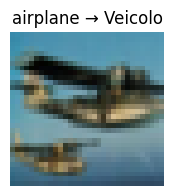

In [19]:
#Visualizzo un'immagine random del dataset con relativa label binaria

idx = np.random.randint(0, len(x_train))
img = x_train[idx]
label_idx = y_train[idx][0]
label = labels[label_idx]
binary_class = binary_labels[label_map[label_idx]]

plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title(f"{label} → {binary_class}")
plt.axis('off')
plt.show()

In [20]:
#Normalizzo il set di train e di test ed appiattisco l'array NumPy delle label

x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

In [ ]:
#Converto y_train e y_test alle nuove etichette binarie

y_train_binary = np.array([label_map[label] for label in y_train])
y_test_binary = np.array([label_map[label] for label in y_test])
x_train, x_test, y_train_binary, y_test_binary

## Implementazione di una rete neurale convoluzionale con Sequential API

In [21]:
# Pulisco la sessione

clear_session()

In [22]:
#Creo la CNN usando un'API sequenziale di Keras adatta alla classificazione di immagini RGB di dimensione 32x32

#Definisco un'inizializzatore di pesi specifico per la funzione di attivazione ReLU

he_init = HeNormal()

cnn = Sequential([
    # Input layer per immagini 32x32 con 3 canali (RGB)
    InputLayer(input_shape=(32, 32, 3)),

    # Primo blocco convoluzionale

    # Convoluzione con 32 filtri 3x3, attivazione ReLU
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    # Normalizzazione dei batch per una maggiore stabilità
    BatchNormalization(),
    # Seconda convoluzione con 32 filtri 3x3
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    # Normalizzazione
    BatchNormalization(),
    # Pooling per ridurre le dimensioni spaziali (da 32x32 a 16x16)
    MaxPool2D(),

    # Secondo blocco convoluzionale

    # Convoluzione con 64 filtri 3x3
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    # Seconda convoluzione con 64 filtri
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    # Pooling (da 16x16 a 8x8)
    MaxPool2D(),

    # Terzo blocco convoluzionale

    # Convoluzione con 128 filtri 3x3
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    # Seconda convoluzione con 128 filtri
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    # Pooling (da 8x8 a 4x4)
    MaxPool2D(),

    # Invece del Flattening sfrutto un Global Average Pooling per ridurre ogni feature map ad un singolo valore tramite media
    GlobalAveragePooling2D(),

    # Dropout al 50% per prevenire l'overfitting
    Dropout(0.5),

    # Dense layer completamente connesso con 256 neuroni
    Dense(256, activation='relu', kernel_initializer=he_init),

    # Altro Dropout al 50% per regolarizzare
    Dropout(0.5),

    # Layer di output con 1 neurone e funzione di attivazione Sigmoide trattandosi di classi binarie
    Dense(1, activation='sigmoid')
])

#Procedo alla compilazione della rete con optimezer Adam ed una loss Binary Crossentropy per classificazione binaria
#Uso come metrica una classica accuracy

cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#Visualizzo la struttura della rete creata

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 322,081 (1.23 MB)

 Trainable params: 321,185 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

In [23]:
#Effettuo il preprocessing dei dati

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

train_generator = data_generator.flow(x_train, y_train_binary, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size

In [24]:
#Instanzio una callback per l'early stopping

early_stop = EarlyStopping(
    monitor='val_loss',     # metrica da monitorare
    patience=3,             # numero di epoche di tolleranza
    restore_best_weights=True # ripristina i pesi migliori alla fine
)

In [25]:
#Definisco una funzione riutilizzabile per trainare il modello, chiamando la callback

def train_model(model, x_train, y_train_binary, x_val, y_val,
                epochs=10,
                callbacks=None):
    history = model.fit(
        x_train, y_train_binary,
        validation_data=(x_val, y_val),
        epochs=epochs,
        callbacks=callbacks
    )
    return history

In [26]:
#Applico la funzione al modello

%%time
hist_cnn = train_model(cnn, x_train, y_train_binary, x_test, y_test_binary, epochs=10, callbacks=[early_stop])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 416s 262ms/step - accuracy: 0.8568 - loss: 0.3746 - val_accuracy: 0.9131 - val_loss: 0.2068
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 417s 246ms/step - accuracy: 0.9259 - loss: 0.1913 - val_accuracy: 0.9414 - val_loss: 0.1500
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 441s 245ms/step - accuracy: 0.9360 - loss: 0.1646 - val_accuracy: 0.9359 - val_loss: 0.1628
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 439s 244ms/step - accuracy: 0.9493 - loss: 0.1351 - val_accuracy: 0.9366 - val_loss: 0.1698
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 385s 246ms/step - accuracy: 0.9558 - loss: 0.1172 - val_accuracy: 0.9535 - val_loss: 0.1176
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 382s 244ms/step - accuracy: 0.9605 - loss: 0.1025 - val_accuracy: 0.9506 - val_loss: 0.1284
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 442s 283ms/step - accuracy: 0.9661 - loss: 0.0897 - val_accuracy: 0.9578 - val_loss: 0.1077
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 445s 247ms/step - ac

## Valutazione del modello

In [39]:
#Definisco una funzione per valutare il modello in termini di accuracy, precision, recall e F1-score

def evaluate_model(model, x_test, y_test_binary, class_names=None):
    # Gestione robusta dei nomi classe per accettare sia dizionari che liste
    if isinstance(class_names, dict):
        class_names = [class_names[i] for i in sorted(class_names)]

    # Valutazione generale (loss e accuracy)
    loss, accuracy = model.evaluate(x_test, y_test_binary, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}\n")

    # Gestione etichette vere
    y_true = np.argmax(y_test_binary, axis=1) if y_test_binary.ndim > 1 else y_test_binary
    y_true = y_true.astype(int)

    # Predizione (sigmoide con soglia 0.5)
    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Report precisione/recall/F1
    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=4, target_names=class_names))

    # Matrice di confusione
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


Test Loss: 0.1031
Test Accuracy: 0.9597

Classification Report:

              precision    recall  f1-score   support

     Veicolo     0.9615    0.9367    0.9490      4000
     Animale     0.9585    0.9750    0.9667      6000

    accuracy                         0.9597     10000
   macro avg     0.9600    0.9559    0.9578     10000
weighted avg     0.9597    0.9597    0.9596     10000



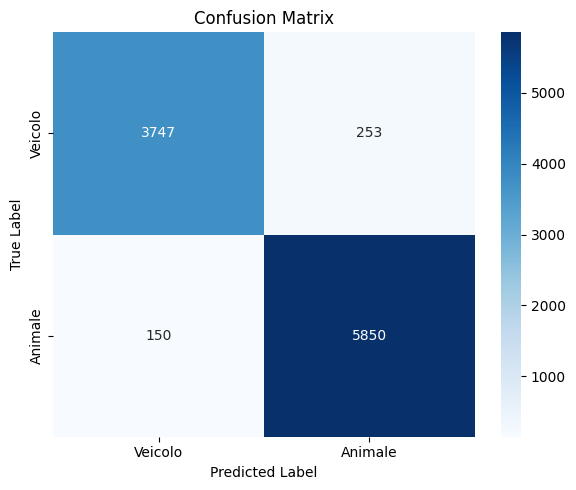

In [34]:
#Applico la funzione di valutazione

evaluate_model(cnn, x_test, y_test_binary, binary_labels)

In [35]:
#Definisco un'ulteriore funzione per la visualizzazione grafica di loss ed accuracy

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

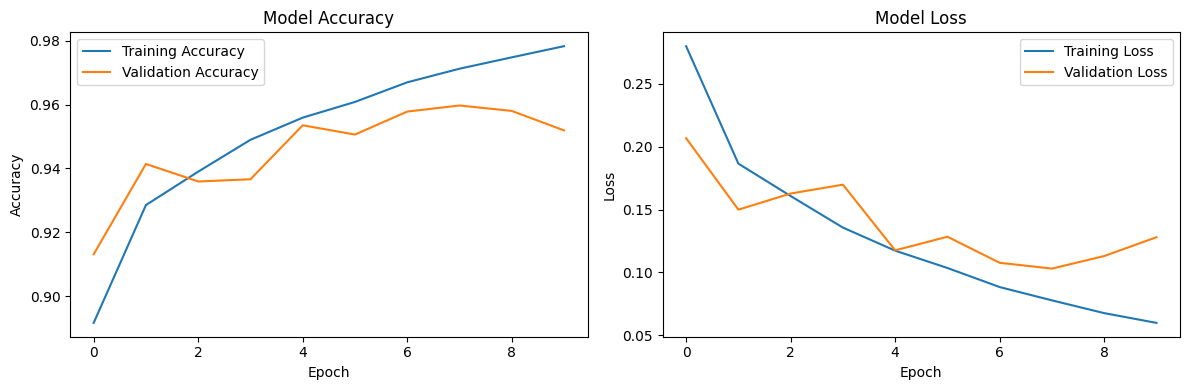

In [36]:
#Visualizzo i risultati del modello sequenziale

plot_history(hist_cnn)

## Analisi dei risultati

In [44]:
#Definisco una funzione per visualizzare le prime n immagini classificate erroneamente con le etichette vere e predette

def plot_misclassified_images(model, x_test, y_test_binary, class_labels=None, n=9):
    # True labels
    y_true = y_test_binary if y_test_binary.ndim == 1 else np.argmax(y_test_binary, axis=1)

   # Predizione (sigmoide con soglia 0.5)
    y_pred_probs = model.predict(x_test, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Trovo gli indici delle immagini errate
    mis_idx = np.where(y_true != y_pred)[0]

    # Visualizzo le prime n immagini errate
    plt.figure(figsize=(8, 8))
    for i, idx in enumerate(mis_idx[:n]):
        ax = plt.subplot(3, 3, i + 1)
        img = x_test[idx]
        plt.imshow(img)
        plt.title(f"Classe corretta: {class_labels[y_true[idx]]}\nClasse predetta: {class_labels[y_pred[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

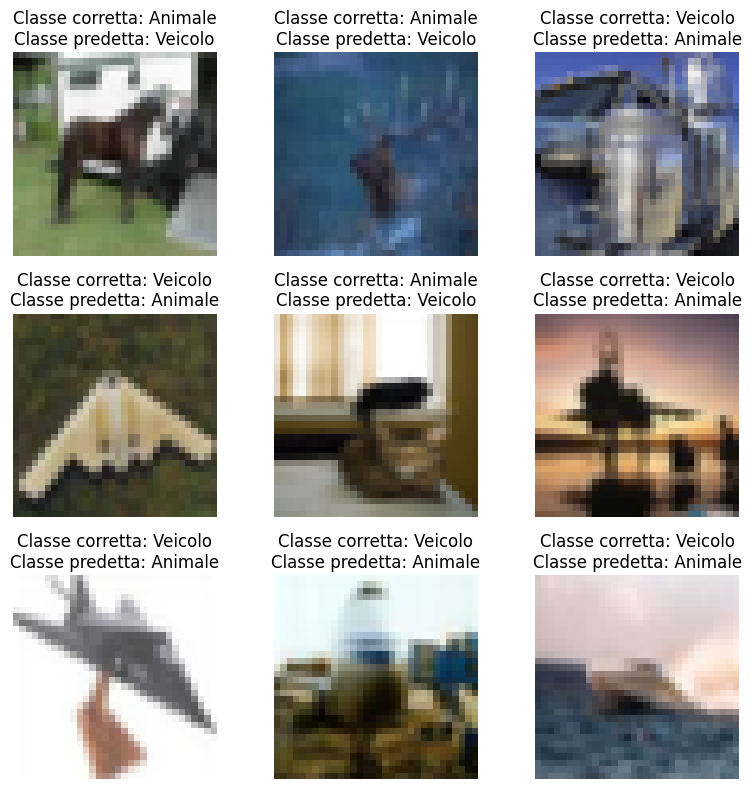

In [45]:
#Applico la funzione appena definita e visualizzo le prime n immagini non classificate correttamente

plot_misclassified_images(cnn, x_test, y_test_binary, class_labels=binary_labels, n=9)

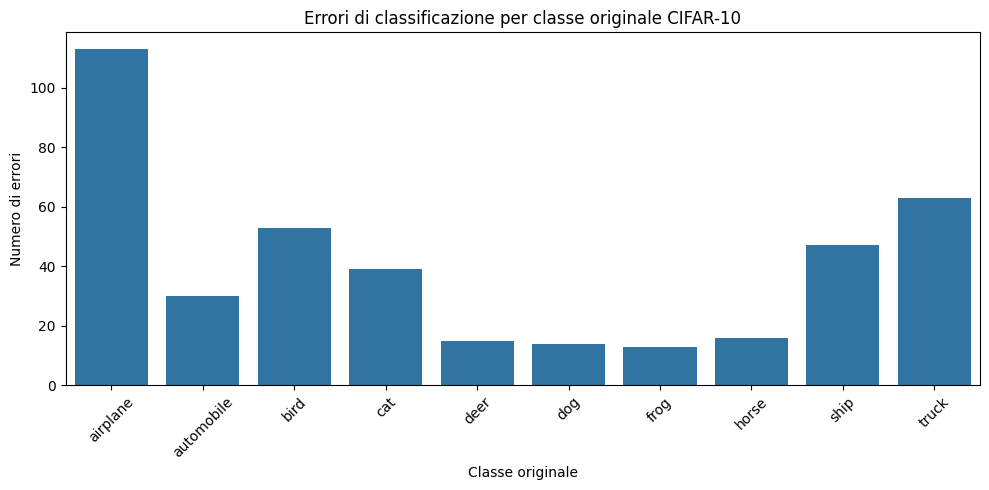

In [47]:
#Analizzo quali classi originali del CIFAR-10 sono maggiormente coinvolte negli errori di classificazione nel modello binario

# Ricalcolo le predizioni
y_pred_probs = cnn.predict(x_test, verbose=0)
y_pred_binary = (y_pred_probs > 0.5).astype(int).flatten()

# Etichette originali (0–9) prese dal dataset
y_test_original = y_test.flatten()

# Trovo gli errori
error_indices = np.where(y_pred_binary != y_test_binary)[0]
error_classes = y_test_original[error_indices]

# Conteggio degli errori per classe CIFAR-10
import pandas as pd
error_class_counts = pd.Series(error_classes).value_counts().sort_index()
error_class_counts.index = [labels[i] for i in error_class_counts.index]

# Visualizzazione
plt.figure(figsize=(10, 5))
sns.barplot(x=error_class_counts.index, y=error_class_counts.values)
plt.title("Errori di classificazione per classe originale CIFAR-10")
plt.ylabel("Numero di errori")
plt.xlabel("Classe originale")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Sintesi dell’analisi dei risultati

Accuracy: 95.97%
→ Il modello ha classificato correttamente circa 96 esempi su 100

Loss: 0.1031
→ Il valore di loss è basso, coerente con una buona performance

Il modello mostra ottime prestazioni complessive nella distinzione tra Veicoli e Animali.

Andando nel dettaglio:

È leggermente più preciso sui veicoli, ma più sensibile sugli animali (riconosce più animali correttamente). Se consideriamo che il costo di errore sugli animali potrebbe essere più critico (facendo riferimento al rilevamento sicurezza), il modello è da considerare attendibile.

La confusione maggiore avviene quando i veicoli vengono scambiati per animali (253 casi).

E' presente un buon bilanciamento, sebbene vi sia una leggera tendenza del modello a favorire la classe “Animale”, più rappresentata nel dataset.

Bisogna fare attenzione alla classificazione dei veicoli, che ha recall un po’ più basso, in particolare alle immagini di aereoplani.

L'andamento mostrato nei grafici relativi ad accuracy e loss, sembrerebbe evidenziare inoltre la presenza di overfitting.

Si può infatti notare che la validation accuracy si stabilizza attorno a 0.95–0.96 ed inizia a peggiorare lievemente dopo alcune epoche. La validation loss, dopo un'iniziale calo, oscilla e poi tende a salire.

## Possibili migliorie al progetto

Potrebbe essere utile aumentare la varietà dei veicoli nel training set o effettuare della data augmentation specifica, aggiungendo rotazioni, zoom o variazioni di luminosità per le immagini.

Da valutare anche un leggero downsampling degli animali per ottenere un migliore bilanciamento delle classi.

Si potrebbe fare riscorso ad L2 regularization nei layer o pensare di ridurre la complessità/profondità del modello ed in particolare il numero di strati, anche per migliorarne le prestazioni computazionali.

## Tentativo di miglioramento del modello

In [48]:
cnn2 = Sequential([
    InputLayer(input_shape=(32, 32, 3)),

    # Blocco 1: riduzione dei filtri
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    MaxPool2D(),

    # Blocco 2
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=he_init),
    BatchNormalization(),
    MaxPool2D(),

    # Rimozione del terzo blocco 128x128 in quanto troppo profondo per dimensioni 32x32
    # e sostituzione con GlobalAveragePooling
    GlobalAveragePooling2D(),

    # Dropout più moderato (es. 0.3)
    Dropout(0.3),

    # Dense più leggero
    Dense(64, activation='relu', kernel_initializer=he_init),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

cnn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,001 (93.75 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 192 (768.00 B)

In [49]:
#Traino il modello

%%time
hist_cnn2 = train_model(cnn2, x_train, y_train_binary, x_test, y_test_binary, epochs=10, callbacks=[early_stop])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 125s 78ms/step - accuracy: 0.8352 - loss: 0.3840 - val_accuracy: 0.8827 - val_loss: 0.2829
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 131s 71ms/step - accuracy: 0.8951 - loss: 0.2608 - val_accuracy: 0.9099 - val_loss: 0.2233
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 135s 66ms/step - accuracy: 0.9107 - loss: 0.2302 - val_accuracy: 0.9188 - val_loss: 0.2074
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 115s 73ms/step - accuracy: 0.9153 - loss: 0.2139 - val_accuracy: 0.9271 - val_loss: 0.1807
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 105s 67ms/step - accuracy: 0.9178 - loss: 0.2072 - val_accuracy: 0.9154 - val_loss: 0.2123
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 103s 66ms/step - accuracy: 0.9212 - loss: 0.1948 - val_accuracy: 0.9258 - val_loss: 0.1944
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 110s 70ms/step - accuracy: 0.9251 - loss: 0.1920 - val_accuracy: 0.9170 - val_loss: 0.2066
CPU times: user 19min 40s, sys: 23.8 s, total: 20min 3s
Wall time: 13

Test Loss: 0.1807
Test Accuracy: 0.9271

Classification Report:

              precision    recall  f1-score   support

     Veicolo     0.9125    0.9045    0.9085      4000
     Animale     0.9367    0.9422    0.9394      6000

    accuracy                         0.9271     10000
   macro avg     0.9246    0.9233    0.9240     10000
weighted avg     0.9270    0.9271    0.9270     10000



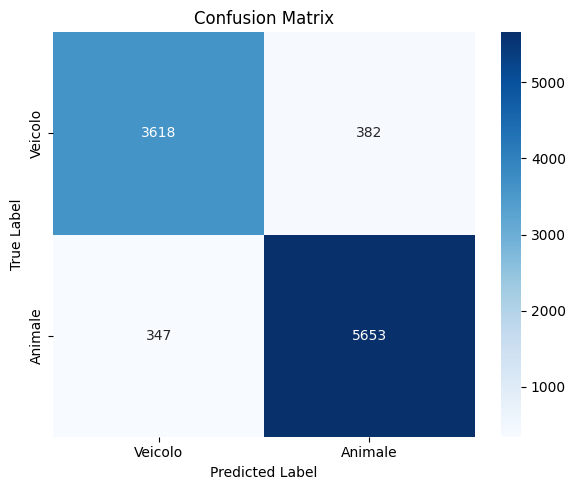

In [50]:
#Applico la funzione di valutazione

evaluate_model(cnn2, x_test, y_test_binary, binary_labels)

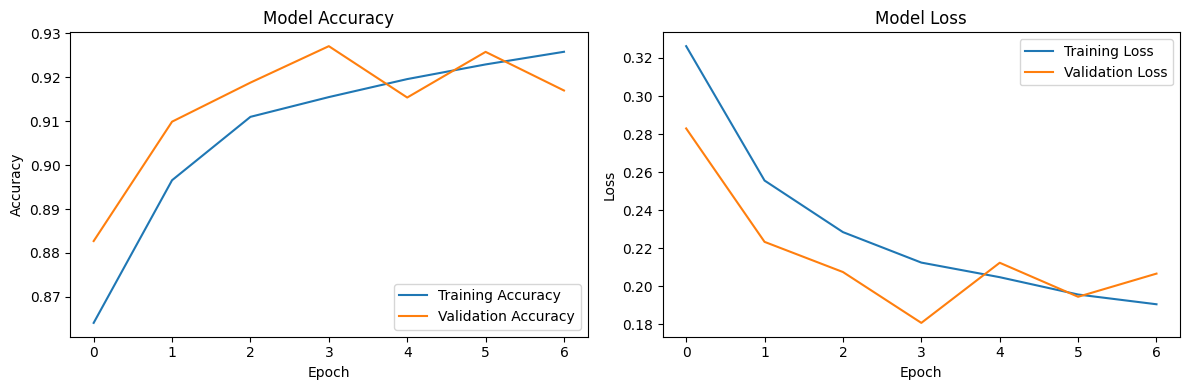

In [52]:
#Visualizzo i risultati del secondo modello sequenziale

plot_history(hist_cnn2)

## Considerazioni in termini di trade-off

Le principali metriche subiscono un lieve peggioramento. Il modello ne guadagna però in termini di prestazioni (tempi di training notevolmente ridotti) e, sebbene in misura minima, anche di overfitting.